## 라이브러리 불러오기

In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

## q(s,a)를 알 때, epsilon-greedy policy함수를 만들어내보자

In [4]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    #빈칸1_Input Q를 maximize하는 action을 얻어내서 채워보자 (이해: 1-epsilon을 나중에 더해주기)
    #단, 실습pdf의 빨간 두번째 빈칸식에 나와있는 epsilon-greedy policy로 만들기
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A #A는 각 action별 확률(action개수만큼의 길이를 가짐)
    return policy_fn

In [5]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    #우리는 MC방법을 이용해서 action-value function Q를 구할것이다.
    # How : 몇 번의 episode를 시행시켜보고, 그 episode들의 G(return)의 평균을 구해서
    # 그 평균값으로 Q를 대체하자. 이를 위해 return G의 총 합과 횟수를 기록하자
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)

    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    #즉 쉽게 말하면, Q는 state x action 크기의 행렬이라고 생각하자
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    #우리는 위에서 만든 epsilon_greedy_policy를 이용할 것이다
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    #각각의 에피소드마다
    for i_episode in range(1, num_episodes + 1):
        # Print out which episode we're on, useful for debugging.
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # 빈칸_2_Generate an episode
        #('1step_MC Prediction'의 빈칸_1 과 거의 비슷, 단 policy만 epsilon_greedy_policy확률에 맞춰서 action 선택)
        #주의: 현재 policy는 각 action별 확률을 나타냄
        episode = []
        state = env.reset()
        for t in range(100):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state

        #sa_in_episode에 위의 episode array에서 방문한 state와 action들만 (state, action) pair를 저장하자
        sa_in_episode = [(x[0], x[1]) for x in episode]
        #각각의 방문했던 (state,action) 마다
        for state, action in sa_in_episode:
            sa_pair = (state, action)
            #밑의빈칸3&4는 실습pdf의 첫번째 빨간 빈칸식 참고
            # 빈칸_3_episode중에 처음으로 그 state에 방문하고 action을 취한 idx를 first_occurence_idx에 저장하자.
            for i,x in enumerate(episode):
                if x[0]==state and x[1]==action:
                    first_occurence_idx=i
                    break
            
            # 빈칸_4_처음 방문한 이후로 reward들을 G에 합하자
            G=0
            for i,x in enumerate(episode[first_occurence_idx:]):
                G += x[2]*(discount_factor**i)
            
            # 계산된 G를 해당 state의 returns_sum에 합하고, returns_count까지 이용하여 평균을 Q에 대입하자
            returns_sum[sa_pair] += G
            returns_count[sa_pair] += 1.0
            #빈칸5_결국 우리가 구하고자 하는 action-value function Q에는 어떤값을 대입??
            ###Q[state][action] = 으로 시작
            Q[state][action] = returns_sum[sa_pair] / returns_count[sa_pair]
    return Q, policy

In [6]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 500000/500000.

## 각 state별 value funtion 값 plot해보기

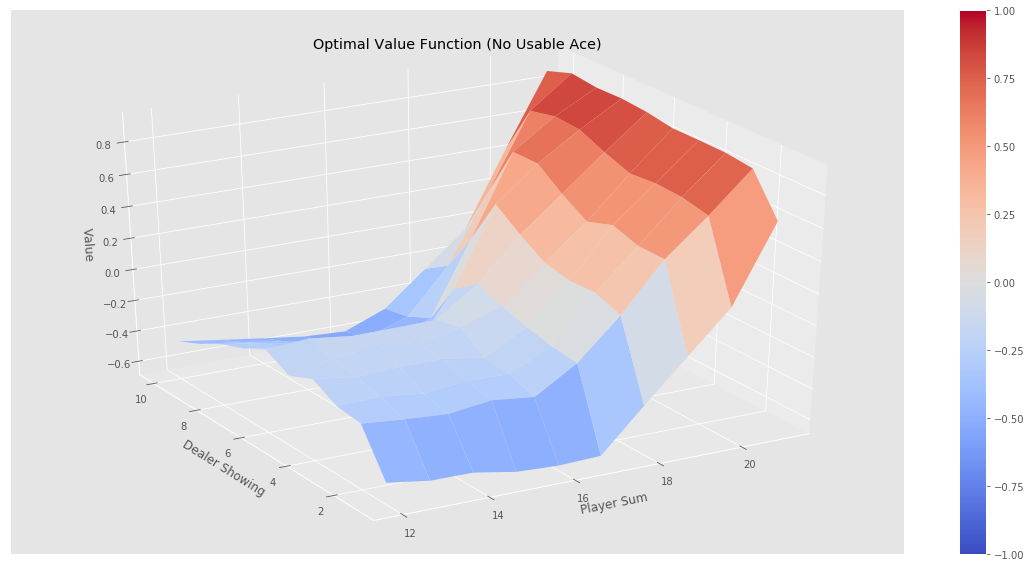

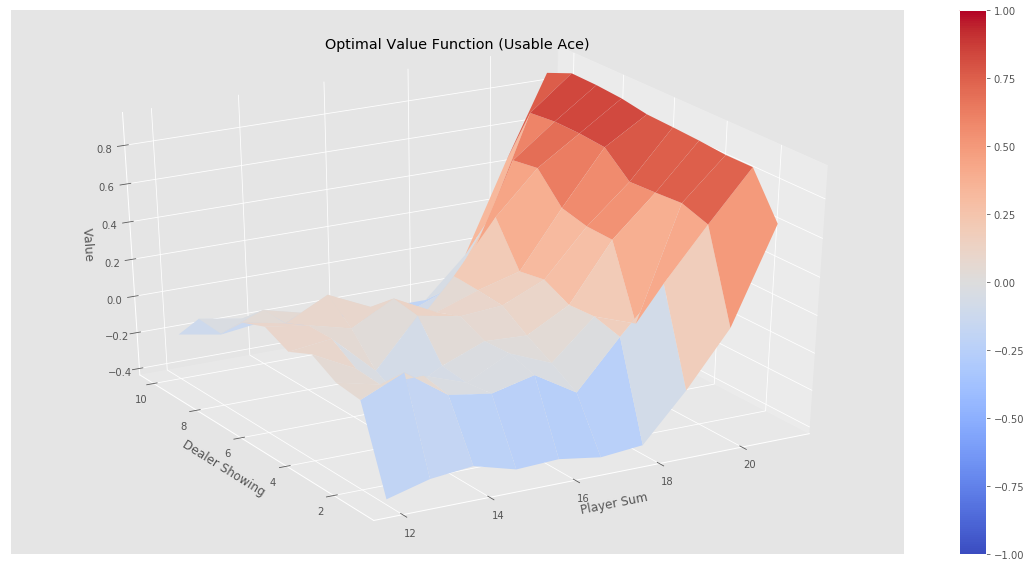

In [7]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

# 우리가 얻어낸 최적의 Policy로 0step에서 했던 실제 블랙잭을 해봅시다!

In [32]:
def print_observation(observation):
    score, dealer_score, usable_ace = observation
    print("Player Score: {} (Usable Ace: {}), Dealer Score: {}".format(
          score, usable_ace, dealer_score))

In [47]:
win=0
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        print_observation(observation)
        action=np.argmax(policy(observation))
        print("Taking action: {}".format( ["Stick", "Hit"][action])) #If action=0, stick. Else action=1, Hit.
        observation, reward, done, _ = env.step(action)
        if done:
            print_observation(observation)
            print("Game end. Reward: {}\n".format(float(reward)))
            if reward==1:
                win+=1
            break
print("we win total ",win,"times!")

Player Score: 17 (Usable Ace: False), Dealer Score: 3
Taking action: Stick
Player Score: 17 (Usable Ace: False), Dealer Score: 3
Game end. Reward: 1.0

Player Score: 18 (Usable Ace: False), Dealer Score: 8
Taking action: Stick
Player Score: 18 (Usable Ace: False), Dealer Score: 8
Game end. Reward: -1.0

Player Score: 18 (Usable Ace: False), Dealer Score: 8
Taking action: Stick
Player Score: 18 (Usable Ace: False), Dealer Score: 8
Game end. Reward: 0.0

Player Score: 15 (Usable Ace: False), Dealer Score: 1
Taking action: Hit
Player Score: 17 (Usable Ace: False), Dealer Score: 1
Taking action: Stick
Player Score: 17 (Usable Ace: False), Dealer Score: 1
Game end. Reward: -1.0

Player Score: 14 (Usable Ace: False), Dealer Score: 5
Taking action: Stick
Player Score: 14 (Usable Ace: False), Dealer Score: 5
Game end. Reward: 1.0

Player Score: 12 (Usable Ace: True), Dealer Score: 8
Taking action: Hit
Player Score: 12 (Usable Ace: False), Dealer Score: 8
Taking action: Hit
Player Score: 19 (Us